In [1]:
#import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.optim import lr_scheduler

In [2]:
torch.manual_seed(7)

In [3]:
transform_ori = transforms.Compose([#transforms.RandomResizedCrop(64),   #create 64x64 image
                                    #transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    
#Load our dataset
train_dataset = datasets.ImageFolder(root = '/scratch/mk7711/dast/datasets/og/wd/train',
                                     transform = transform_ori)

test_dataset = datasets.ImageFolder(root = '/scratch/mk7711/dast/datasets/og/wd/test',
                                    transform = transform_ori)


#Make the dataset iterable
batch_size = 32
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)      #Shuffle to create a mixed batches of 100 of cat & dog images

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


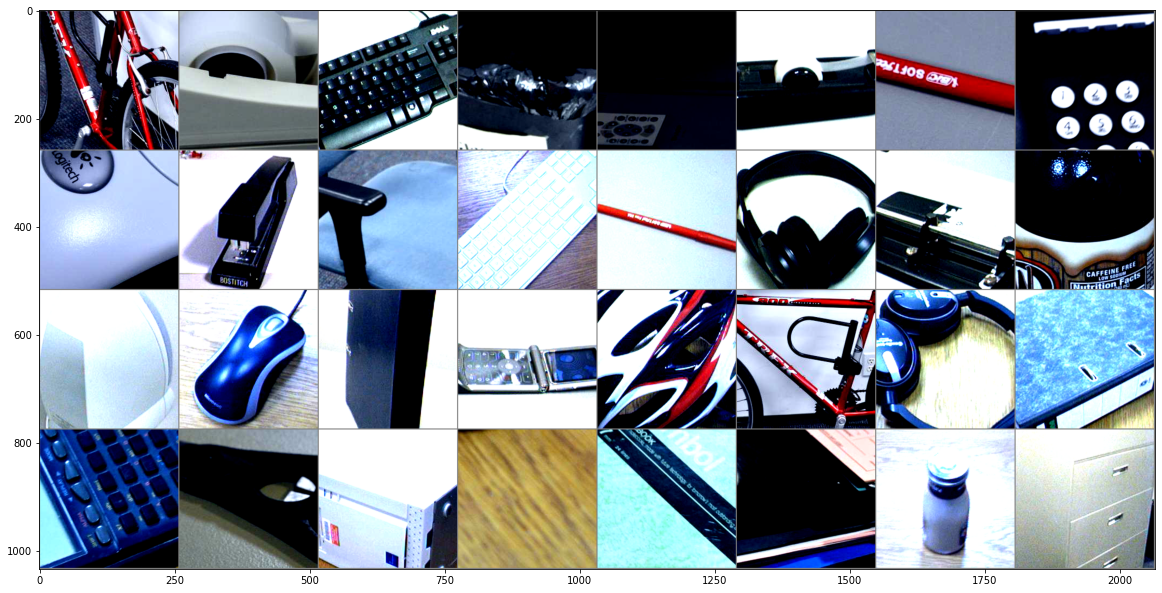

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 64/2 = 32
        
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)  
        
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1, padding=1)
        self.batchnorm4= nn.BatchNorm2d(128)        #Batch normalization
                        #RELU Activation
        self.maxpool4= nn.MaxPool2d(kernel_size=2)  
        
        self.cnn5= nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.batchnorm5= nn.BatchNorm2d(256)
        self.relu = nn.ReLU() 
        self.maxpool5= nn.MaxPool2d(kernel_size=2)
        
        self.cnn6= nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.batchnorm6= nn.BatchNorm2d(512)
        self.maxpool6= nn.MaxPool2d(kernel_size=2)#Size now is 32/2 = 16
        
        #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
        self.fc1 = nn.Linear(in_features=8192, out_features=1000)   #Flattened image is fed into linear NN and reduced to half size
        self.droput = nn.Dropout(p=0.7)                    #Dropout used to reduce overfitting
        #self.fc2 = nn.Linear(in_features=16000, out_features=8000)
        #self.droput = nn.Dropout(p=0.5)
        #self.fc3 = nn.Linear(in_features=10000, out_features=1000)
        #self.droput = nn.Dropout(p=0.5)
        #self.fc4 = nn.Linear(in_features=1000, out_features=100)
        #self.droput = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=1000, out_features=31)    #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
       
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        
        out = self.cnn3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool3(out)
        
        out = self.cnn4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.maxpool4(out)
        
        out = self.cnn5(out)
        out = self.batchnorm5(out)
        out = self.relu(out)
        out = self.maxpool5(out)
        
        out = self.cnn6(out)
        out = self.batchnorm6(out)
        out = self.relu(out)
        out = self.maxpool6(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,8192)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        #out = self.fc2(out)
        #out = self.relu(out)
        #out = self.droput(out)
        #out = self.fc3(out)
        #out = self.relu(out)
        #out = self.droput(out)
        #out = self.fc4(out)
        #out = self.relu(out)
        #out = self.droput(out)
        out = self.fc5(out)
        return out

In [6]:
model = CNN()
print(model)
CUDA = torch.cuda.is_available()
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)
#optimizer = torch.optim.Adam(model.parameters(),
                       #lr = 0.01,
                       #weight_decay= 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

CNN(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2

In [ ]:
import time

num_epochs = 50

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    scheduler.step()
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = inputs  #variable not necessary
        labels = labels
        
        CUDA = torch.cuda.is_available()
        if CUDA:  #requires only once 
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
    del inputs, labels, outputs, predicted
    torch.cuda.empty_cache()
    #Testing
    loss_1 = 0.0
    correct = 0
    iterations = 0
    
    model.eval()                    # Put the network into evaluation mode
 

    for i, (inputs, labels) in enumerate(test_load):
        with torch.no_grad():
                  # Convert torch tensor to Variable
            inputs = inputs
            labels = labels
        
            CUDA = torch.cuda.is_available()
            if CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()
        
            outputs = model(inputs)     
            loss = loss_fn(outputs, labels) # Calculate the loss
            loss_1 += loss.item() #data
            # Record the correct predictions for training data
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()

            iterations += 1

    # Record the Testing loss
    test_loss.append(loss_1/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    del inputs, labels, outputs, predicted
    torch.cuda.empty_cache()
    stop = time.time()
    #print("Learning Rate: ", scheduler.get_lr())
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))


hello


/home/mk7711/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50, Training Loss: 3.280, Training Accuracy: 10.673, Testing Loss: 3.484, Testing Acc: 5.857, Time: 69.19306778907776s
hello
Epoch 2/50, Training Loss: 2.893, Training Accuracy: 21.810, Testing Loss: 3.865, Testing Acc: 5.999, Time: 59.43588137626648s
hello
Epoch 3/50, Training Loss: 2.560, Training Accuracy: 30.317, Testing Loss: 3.706, Testing Acc: 7.419, Time: 90.63235712051392s
hello
Epoch 4/50, Training Loss: 2.247, Training Accuracy: 38.824, Testing Loss: 4.132, Testing Acc: 6.745, Time: 84.4509437084198s
hello
Epoch 5/50, Training Loss: 2.024, Training Accuracy: 44.702, Testing Loss: 4.102, Testing Acc: 5.893, Time: 87.66713070869446s
hello
Epoch 6/50, Training Loss: 1.828, Training Accuracy: 50.812, Testing Loss: 4.114, Testing Acc: 7.206, Time: 145.54722380638123s
hello
Epoch 7/50, Training Loss: 1.616, Training Accuracy: 56.071, Testing Loss: 4.506, Testing Acc: 5.893, Time: 257.8784382343292s
hello
Epoch 8/50, Training Loss: 1.424, Training Accuracy: 60.480, Testing 

In [ ]:
92, 62